<a href="https://colab.research.google.com/github/ZulfiiaDitto/SAM3/blob/main/SAM3_text_prompting_medical_microscopy_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Configure your API keys

To pull Segment Anything 3 weights, you need a HuggingFace Access Token with approved access to the SAM3 checkpoints.
Steps you need to do:

1. Request access to the SAM3 from official Hugging Face [repo](https://github.com/facebookresearch/sam3).
2. Open your HuggingFace Settings page. Click Access Tokens then New Token to generate a new token.
3. Go to the left pane in Colab and click on Secrets (🔑). Store your HuggingFace Access Token under the name `HF_TOKEN`.








In [1]:
import os
from google.colab import userdata

os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Tue Dec  2 03:40:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import torch
import torchvision

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.9.0+cu126
Torchvision version: 0.24.0+cu126
CUDA is available: True


### Install SAM 3 and extra dependencies

In [4]:
!git clone https://github.com/facebookresearch/sam3.git
%cd sam3
!pip install -e ".[notebooks]"
%cd /content

fatal: destination path 'sam3' already exists and is not an empty directory.
/content/sam3
Obtaining file:///content/sam3
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for sam3 (pyproject.toml) ... done
  Created wheel for sam3: filename=sam3-0.1.0-0.editable-py3-none-any.whl size=15197 sha256=9865ce9a35291686f1bad50941c99f311037de13ca81cd017f143d164a3a5e6c
  Stored in directory: /tmp/pip-ephem-wheel-cache-ah60fyn2/wheels/7c/90/be/80339bb9db8655024d6c9501da4e5efc6abbda4c897f5a6c43
Successfully built sam3
  Attempting uninstall: sam3
    Found existing installation: sam3 0.1.0
    Uninstalling sam3-0.1.0:
      Successfully uninstalled sam3-0.1.0
/content


In [5]:
!pip install -q supervision jupyter_bbox_widget

## Load SAM3 Image Predictor


In [7]:
import torch

torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [8]:
from sam3.model_builder import build_sam3_image_model
from sam3.model.sam3_image_processor import Sam3Processor

model = build_sam3_image_model()
processor = Sam3Processor(model, confidence_threshold=0.3)

config.json:   0%|          | 0.00/25.8k [00:00<?, ?B/s]

sam3.pt:   0%|          | 0.00/3.45G [00:00<?, ?B/s]

## Few utils to parse and visualize the result

In [9]:
import supervision as sv

def from_sam(sam_result: dict) -> sv.Detections:
    xyxy = sam_result["boxes"].to(torch.float32).cpu().numpy()
    confidence = sam_result["scores"].to(torch.float32).cpu().numpy()

    mask = sam_result["masks"].to(torch.bool)
    mask = mask.reshape(mask.shape[0], mask.shape[2], mask.shape[3]).cpu().numpy()

    return sv.Detections(
        xyxy=xyxy,
        confidence=confidence,
        mask=mask
    )

In [10]:
import supervision as sv
from PIL import Image
from typing import Optional


COLOR = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])


def annotate(image: Image.Image, detections: sv.Detections, label: Optional[str] = None) -> Image.Image:
    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)

    mask_annotator = sv.MaskAnnotator(
        color=COLOR,
        color_lookup=sv.ColorLookup.INDEX,
        opacity=0.6
    )
    box_annotator = sv.BoxAnnotator(
        color=COLOR,
        color_lookup=sv.ColorLookup.INDEX,
        thickness=1
    )
    label_annotator = sv.LabelAnnotator(
        color=COLOR,
        color_lookup=sv.ColorLookup.INDEX,
        text_scale=0.4,
        text_padding=5,
        text_color=sv.Color.BLACK,
        text_thickness=1
    )

    annotated_image = image.copy()
    annotated_image = mask_annotator.annotate(annotated_image, detections)
    annotated_image = box_annotator.annotate(annotated_image, detections)

    if label:
        labels = [
            f"{label} {confidence:.2f}"
            for confidence in detections.confidence
        ]
        annotated_image = label_annotator.annotate(annotated_image, detections, labels)

    return annotated_image

## SAM 3 text prompt

There are 137 cells objects detected in the image.



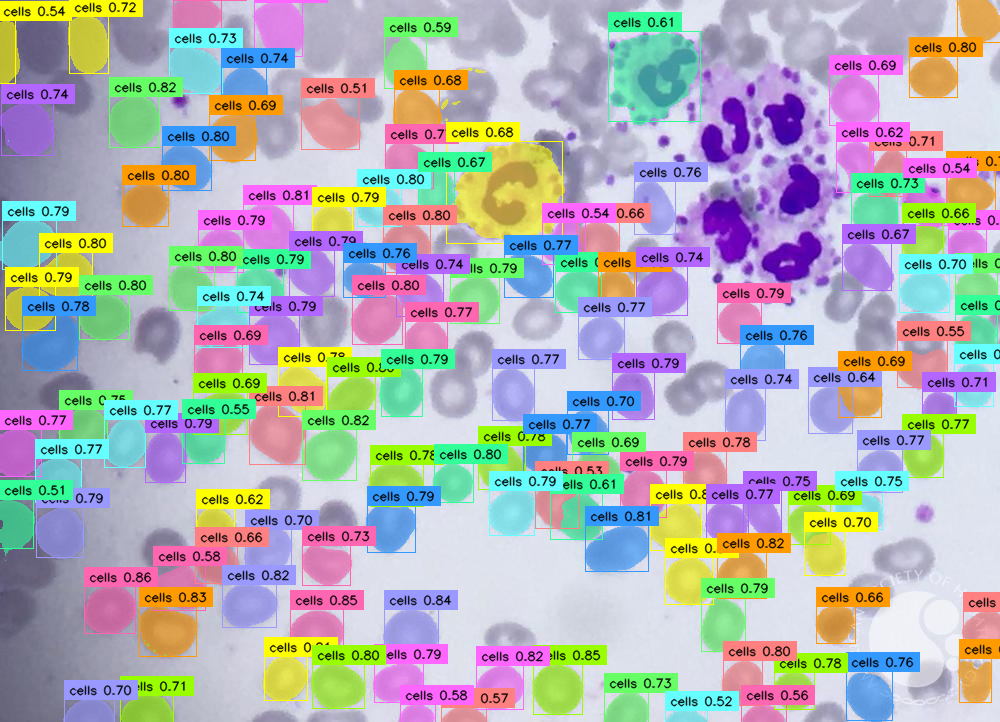

In [26]:
from PIL import Image
from IPython.display import display

PROMPT = "cells"
IMAGE_PATH = '/content/63636-Platelet satellitism.Jpeg'

image = Image.open(IMAGE_PATH).convert("RGB")
inference_state = processor.set_image(image)
inference_state = processor.set_text_prompt(state=inference_state, prompt=PROMPT)

detections = from_sam(sam_result=inference_state)
detections = detections[detections.confidence > 0.5]

print(f"There are {len(detections)} {PROMPT} objects detected in the image.\n")
annotate(image, detections, label=PROMPT)

## SAM 3 box prompt

In [13]:
import base64
from io import BytesIO
from PIL import Image

OBJECTS = ['positive', 'negative']

def encode_image_pillow(image: Image.Image) -> str:
    buffer = BytesIO()
    image.save(buffer, format="JPEG")
    image_bytes = buffer.getvalue()
    encoded = base64.b64encode(image_bytes).decode("utf-8")
    return "data:image/jpeg;base64," + encoded

When prompting SAM 3 with bounding boxes, the model expects boxes in the `xcycwh` format (`x_center`, `y_center`, `width`, `height`), and the coordinates must be normalized. The code below handles the conversion to this format.

In [14]:
import numpy as np

def get_normalized_boxes(bboxes, label, resolution_wh):
    width, height = resolution_wh
    boxes = [
        [b["x"] + b["width"] / 2, b["y"] + b["height"] / 2, b["width"], b["height"]]
        for b in bboxes
        if b["label"] == label
    ]
    if not boxes:
        return np.empty((0, 4), dtype=np.float32)
    scale = np.array([width, height, width, height], dtype=np.float32).reshape(1,-1)
    return np.array(boxes, dtype=np.float32) / scale

In [15]:
from PIL import Image
from jupyter_bbox_widget import BBoxWidget

image_path = '/content/63636-Platelet satellitism.Jpeg'
image = Image.open(image_path).convert("RGB")

widget = BBoxWidget(classes=OBJECTS)
widget.image = encode_image_pillow(image)
widget

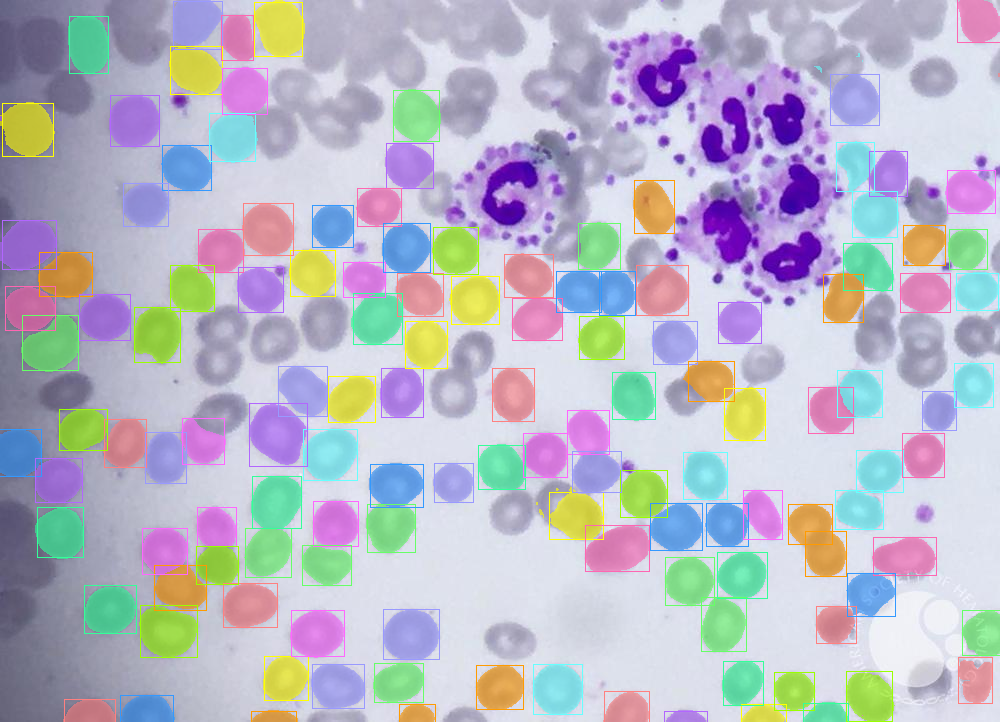

In [16]:
xyxy_positive = get_normalized_boxes(widget.bboxes, "positive", image.size)
xyxy_negatives = get_normalized_boxes(widget.bboxes, "negative", image.size)

inference_state = processor.set_image(image)
processor.reset_all_prompts(inference_state)

for box in xyxy_positive:
    inference_state = processor.add_geometric_prompt(state=inference_state, box=box, label=True)
for box in xyxy_negatives:
    inference_state = processor.add_geometric_prompt(state=inference_state, box=box, label=False)

detections = from_sam(sam_result=inference_state)
detections = detections[detections.confidence > 0.5]
annotate(image, detections)

In [27]:
!    pip install --upgrade notebook jupyterlab ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 125.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 88.2 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
  Attempting uninstall: notebook
    Found existing installation: notebook 6.5.7
    Uninstalling notebook-6.5.7:
      Successfully uninstalled notebook-6.5.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-kernel-gateway 2.5.2 requires notebook<7.0,>=5.7